# Group Galaxy Catalog for the DR5 Gallery

The purpose of this notebook is to build a group catalog (using a simple friends-of-friends algorithm) from a diameter-limited (*D25>5* arcsec) parent sample of galaxies defined and documented as part of the [Legacy Survey Large Galaxy Atlas](https://github.com/moustakas/LSLGA). 

## Preliminaries

Import the libraries we need, define the I/O path, and specify the desired linking length (in arcminutes) and the minimum D(25) of the galaxy sample.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord

In [3]:
import fitsio
from pydl.pydlutils.spheregroup import spheregroup

In [4]:
%matplotlib inline

In [5]:
LSLGAdir = os.getenv('LSLGA_DIR')

In [6]:
mindiameter = 0.25 # [arcmin]
linking_length = 2.5 # [arcmin]

## Read the parent HyperLeda catalog.

We immediately throw out objects with objtype='g' in Hyperleda, which are "probably extended" and many (most? all?) have incorrect D(25) diameters.  We also toss out objects with D(25)>2.5 arcmin and B>16, which are also probably incorrect.

In [7]:
suffix = '0.05'

In [8]:
ledafile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-{}.fits'.format(suffix))
leda = Table.read(ledafile)

keep = (np.char.strip(leda['OBJTYPE']) != 'g') * (leda['D25'] / 60 > mindiameter)
leda = leda[keep]

keep = ['SDSS' not in gg and '2MAS' not in gg for gg in leda['GALAXY']]
#keep = np.logical_and( (np.char.strip(leda['OBJTYPE']) != 'g'), ~((leda['D25'] / 60 > 2.5) * (leda['BMAG'] > 16)) )
leda = leda[keep]
leda

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32
PGC622563,PGC0622563,0.00045,-37.47607,,G,,17.7073,0.758578,128.0,17.75,15.84,-999.0
PGC1982072,PGC1982072,0.0006,32.1366,,G,,19.4156,0.74131,136.5,17.78,-999.0,-999.0
PGC535833,PGC0535833,0.0006,-44.57789,,G,,20.3306,0.588844,148.5,17.63,17.14,-999.0
PGC520795,PGC0520795,0.00075,-45.95405,,G,,20.3306,0.676083,24.7,17.54,15.5,-999.0
PGC1961515,PGC1961515,0.00075,31.7311,,G,,23.3427,0.616595,160.3,17.38,-999.0,-999.0
PGC228194,PGC0228194,0.0009,-80.24194,,G,,19.8679,0.707946,175.0,17.78,15.61,-999.0
PGC124374,PGC0124374,0.00135,-41.42293,,G,,22.2921,0.954993,-999.0,16.82,15.05,18488.0
PGC398935,PGC0398935,0.0015,-56.58832,,G,,15.7816,0.616595,15.5,18.33,16.04,55701.0
PGC2058887,PGC2058887,0.0018,35.06725,,G,,20.3306,0.724436,118.1,17.36,-999.0,-999.0


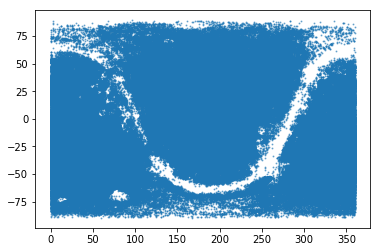

In [9]:
fig, ax = plt.subplots()
ax.scatter(leda['RA'], leda['DEC'], s=1, alpha=0.5)

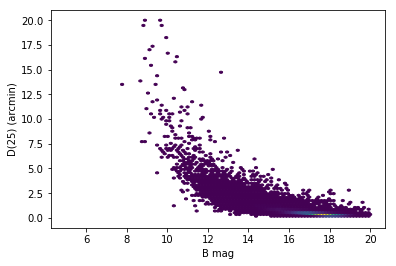

In [10]:
fig, ax = plt.subplots()
ax.hexbin(leda['BMAG'], leda['D25'] / 60, extent=(5, 20, 0, 20),
          mincnt=1)
ax.set_xlabel('B mag')
ax.set_ylabel('D(25) (arcmin)')

In [11]:
if False:
    these = (leda['RA'] > 200) * (leda['RA'] < 210) * (leda['DEC'] > 5) * (leda['DEC'] < 10.0)
    leda = leda[these]
    print(np.sum(these))

## Run FoF with spheregroup

Identify groups using a simple angular linking length.  Then construct a catalog of group properties.

In [12]:
%time grp, mult, frst, nxt = spheregroup(leda['RA'], leda['DEC'], linking_length / 60.0)

CPU times: user 6min 43s, sys: 3.11 s, total: 6min 46s
Wall time: 6min 47s


In [13]:
npergrp, _ = np.histogram(grp, bins=len(grp), range=(0, len(grp)))
nbiggrp = np.sum(npergrp > 1).astype('int')
nsmallgrp = np.sum(npergrp == 1).astype('int')
ngrp = nbiggrp + nsmallgrp

In [14]:
print('Found {} total groups, including:'.format(ngrp))
print('  {} groups with 1 member'.format(nsmallgrp))
print('  {} groups with 2-5 members'.format(np.sum( (npergrp > 1)*(npergrp <= 5) ).astype('int')))
print('  {} groups with 5-10 members'.format(np.sum( (npergrp > 5)*(npergrp <= 10) ).astype('int')))
print('  {} groups with >10 members'.format(np.sum( (npergrp > 10) ).astype('int')))

Found 713903 total groups, including:
  611300 groups with 1 member
  100532 groups with 2-5 members
  1790 groups with 5-10 members
  281 groups with >10 members


## Populate the output group catalog

Also add GROUPID to parent catalog to make it easier to cross-reference the two tables.  D25MAX and D25MIN are the maximum and minimum D(25) diameters of the galaxies in the group.

In [15]:
groupcat = Table()
groupcat.add_column(Column(name='GROUPID', dtype='i4', length=ngrp, data=np.arange(ngrp))) # unique ID number
groupcat.add_column(Column(name='GALAXY', dtype='S1000', length=ngrp))
groupcat.add_column(Column(name='NMEMBERS', dtype='i4', length=ngrp))
groupcat.add_column(Column(name='RA', dtype='f8', length=ngrp))  # average RA
groupcat.add_column(Column(name='DEC', dtype='f8', length=ngrp)) # average Dec
groupcat.add_column(Column(name='DIAMETER', dtype='f4', length=ngrp))
groupcat.add_column(Column(name='D25MAX', dtype='f4', length=ngrp))
groupcat.add_column(Column(name='D25MIN', dtype='f4', length=ngrp))

In [16]:
leda_groupid = leda.copy()
leda_groupid.add_column(Column(name='GROUPID', dtype='i4', length=len(leda)))
leda_groupid

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO,GROUPID
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32,int32
PGC622563,PGC0622563,0.00045,-37.47607,,G,,17.7073,0.758578,128.0,17.75,15.84,-999.0,0
PGC1982072,PGC1982072,0.0006,32.1366,,G,,19.4156,0.74131,136.5,17.78,-999.0,-999.0,0
PGC535833,PGC0535833,0.0006,-44.57789,,G,,20.3306,0.588844,148.5,17.63,17.14,-999.0,0
PGC520795,PGC0520795,0.00075,-45.95405,,G,,20.3306,0.676083,24.7,17.54,15.5,-999.0,0
PGC1961515,PGC1961515,0.00075,31.7311,,G,,23.3427,0.616595,160.3,17.38,-999.0,-999.0,0
PGC228194,PGC0228194,0.0009,-80.24194,,G,,19.8679,0.707946,175.0,17.78,15.61,-999.0,0
PGC124374,PGC0124374,0.00135,-41.42293,,G,,22.2921,0.954993,-999.0,16.82,15.05,18488.0,0
PGC398935,PGC0398935,0.0015,-56.58832,,G,,15.7816,0.616595,15.5,18.33,16.04,55701.0,0
PGC2058887,PGC2058887,0.0018,35.06725,,G,,20.3306,0.724436,118.1,17.36,-999.0,-999.0,0


#### Groups with one member--

In [17]:
smallindx = np.arange(nsmallgrp)

In [18]:
ledaindx = np.where(npergrp == 1)[0]
groupcat['RA'][smallindx] = leda['RA'][ledaindx]
groupcat['DEC'][smallindx] = leda['DEC'][ledaindx]
groupcat['NMEMBERS'][smallindx] = 1
groupcat['GALAXY'][smallindx] = np.char.strip(leda['GALAXY'][ledaindx])
groupcat['DIAMETER'][smallindx] = leda['D25'][ledaindx] # [arcsec]
groupcat['D25MAX'][smallindx] = leda['D25'][ledaindx]   # [arcsec]
groupcat['D25MIN'][smallindx] = leda['D25'][ledaindx]   # [arcsec]

leda_groupid['GROUPID'][ledaindx] = groupcat['GROUPID'][smallindx]

#### Groups with more than one member--

In [19]:
bigindx = np.arange(nbiggrp) + nsmallgrp

In [20]:
coord = SkyCoord(ra=leda['RA']*u.degree, dec=leda['DEC']*u.degree)

In [21]:
def biggroups():
    for grpindx, indx in zip(bigindx, np.where(npergrp > 1)[0]):

        ledaindx = np.where(grp == indx)[0]
        _ra, _dec = np.mean(leda['RA'][ledaindx]), np.mean(leda['DEC'][ledaindx])
        d25min, d25max = np.min(leda['D25'][ledaindx]), np.max(leda['D25'][ledaindx])
    
        groupcat['RA'][grpindx] = _ra
        groupcat['DEC'][grpindx] = _dec
        groupcat['D25MAX'][grpindx] = d25max
        groupcat['D25MIN'][grpindx] = d25min

        groupcat['NMEMBERS'][grpindx] = len(ledaindx)
        groupcat['GALAXY'][grpindx] = ','.join(np.char.strip(leda['GALAXY'][ledaindx]))
        leda_groupid['GROUPID'][ledaindx] = groupcat['GROUPID'][grpindx]

        # Get the distance of each object from the group center.
        cc = SkyCoord(ra=_ra*u.degree, dec=_dec*u.degree)
        diameter = 2 * coord[ledaindx].separation(cc).arcsec.max()

        groupcat['DIAMETER'][grpindx] = np.max( (diameter*1.02, d25max) )

In [22]:
%time biggroups()

/usr/local/anaconda3/envs/LSLGA/lib/python3.6/site-packages/ipykernel_launcher.py:14: StringTruncateWarning: truncated right side string(s) longer than 1000 character(s) during assignment
  


CPU times: user 13min 13s, sys: 3.67 s, total: 13min 16s
Wall time: 13min 23s


In [23]:
leda_groupid

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO,GROUPID
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32,int32
PGC622563,PGC0622563,0.00045,-37.47607,,G,,17.7073,0.758578,128.0,17.75,15.84,-999.0,0
PGC1982072,PGC1982072,0.0006,32.1366,,G,,19.4156,0.74131,136.5,17.78,-999.0,-999.0,611300
PGC535833,PGC0535833,0.0006,-44.57789,,G,,20.3306,0.588844,148.5,17.63,17.14,-999.0,1
PGC520795,PGC0520795,0.00075,-45.95405,,G,,20.3306,0.676083,24.7,17.54,15.5,-999.0,611301
PGC1961515,PGC1961515,0.00075,31.7311,,G,,23.3427,0.616595,160.3,17.38,-999.0,-999.0,611302
PGC228194,PGC0228194,0.0009,-80.24194,,G,,19.8679,0.707946,175.0,17.78,15.61,-999.0,2
PGC124374,PGC0124374,0.00135,-41.42293,,G,,22.2921,0.954993,-999.0,16.82,15.05,18488.0,3
PGC398935,PGC0398935,0.0015,-56.58832,,G,,15.7816,0.616595,15.5,18.33,16.04,55701.0,611303
PGC2058887,PGC2058887,0.0018,35.06725,,G,,20.3306,0.724436,118.1,17.36,-999.0,-999.0,4


In [24]:
groupcat

GROUPID,GALAXY,NMEMBERS,RA,DEC,DIAMETER,D25MAX,D25MIN
int32,bytes1000,int32,float64,float64,float32,float32,float32
0,PGC622563,1,0.00045,-37.47607,17.7073,17.7073,17.7073
1,PGC535833,1,0.0006,-44.57789,20.3306,20.3306,20.3306
2,PGC228194,1,0.0009,-80.24194,19.8679,19.8679,19.8679
3,PGC124374,1,0.00135,-41.42293,22.2921,22.2921,22.2921
4,PGC2058887,1,0.0018,35.06725,20.3306,20.3306,20.3306
5,PGC1985872,1,0.0024,32.20919,36.9957,36.9957,36.9957
6,PGC1283524,1,0.00255,5.4425,36.1536,36.1536,36.1536
7,PGC582652,1,0.003,-40.77056,20.3306,20.3306,20.3306
8,PGC993697,1,0.00315,-9.22226,16.5254,16.5254,16.5254


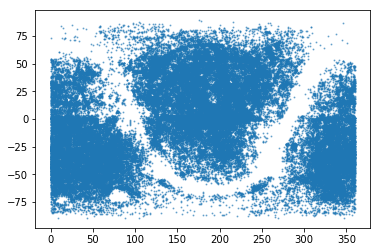

In [25]:
ww = np.where(groupcat['NMEMBERS'] >= 2)[0]
fig, ax = plt.subplots()
ax.scatter(groupcat['RA'][ww], groupcat['DEC'][ww], s=1, alpha=0.5)

In [26]:
groupfile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-{}-groupcat.fits'.format(suffix))
print('Writing {}'.format(groupfile))
groupcat.write(groupfile, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/leda-logd25-0.05-groupcat.fits


In [27]:
ledafile_groupid = os.path.join(LSLGAdir, 'sample', 'leda-logd25-{}-groupid.fits'.format(suffix))
print('Writing {}'.format(ledafile_groupid))
leda_groupid.write(ledafile_groupid, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/leda-logd25-0.05-groupid.fits
